<a href="https://colab.research.google.com/github/bdandersen-berkeley/mids/blob/master/W207/homework/brad_andersen_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [0]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [0]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

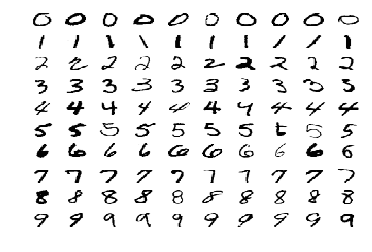

In [0]:
def get_example_digit_indices(digit_list, num_examples = 10):
    """
    Retrieves randomly-selected indices within MNIST data identifying digits 0 through 9.

    Indices are returned as a list of lists: the former list of length 10, one list per digit in
    zero-indexed numeric order; the latter lists being indices within specified MNIST data 
    classified as a digit associated with the list (e.g. indices of 0s in one list, indices
    of 1s in the next, etc.)

    Arguments
    ---------
    digit_list: list
    
    List of numbers whose values identify digit classifications (e.g. '3', '5') and
    whose indices map to the digit's data within the MNIST image data (required)

    num_examples: int
    
    Number of examples of each digit to identify and whose indices to retrieve
    (default: 10)

    Returns
    -------
    List of lists.  Specifically, 10 lists (one for each digit 0 through 9) of indices within 
    MNIST digit image data.  Each index is associated with image data for a digit of the
    associated classification (i.e. the first list contains a list of indices identifying images
    classified as 0s, the second list contains a list of indices identifying images classified as
    1s, etc.)
    """

    assert (type(digit_list) is np.ndarray), "digit_list must be of type NumPy ndarray"
    assert (digit_list.size > 0), "digit_list must not be empty"
    assert (type(num_examples) is int), "num_examples must be of type int"
    assert (0 < num_examples & num_examples <= 10), "num_examples must be an int between 1 and 10"

    # Create the list of lists to populate with image indices
    digit_indices = [[] for i in range(10)]

    # How many lists we have filled with the requisite number of digit indices
    complete_index_lists = 0

    # Randomly select an index from which to be sourcing image data.  Because we iterate through
    # the data and loop to the beginning should we reach the end of the data without completing 
    # all 10 lists, also identify the index at which to stop.
    current_digit_list_idx = np.random.randint(1, digit_list.size)
    final_digit_list_idx = current_digit_list_idx - 1

    # Iterate through the digit data, exiting only if we've filled all 10 lists with the requisite
    # number of digit indices, or if we've sourced/examined all digit data
    while (complete_index_lists < 10 and current_digit_list_idx != final_digit_list_idx):

        # Get the element, ensuring it is a string representing a single digit (e.g. '3', '5')
        example_digit = digit_list[current_digit_list_idx]
        if (type(example_digit) is str and example_digit.isdigit() and len(example_digit) == 1):

            # Convert digit string to integer value
            example_digit = int(example_digit)
            
            # If the list of indices associated with this digit is not filled to the requisite
            # number, append it to the list
            if (len(digit_indices[example_digit]) < num_examples):
                digit_indices[example_digit].append(current_digit_list_idx)

                # If the list of indices is now filled, increment the number of completed lists
                if (len(digit_indices[example_digit]) == num_examples):
                    complete_index_lists += 1

        # Move to the next element in the digit data
        current_digit_list_idx += 1
        if (current_digit_list_idx == digit_list.size):
            current_digit_list_idx = 0

    return digit_indices

def P1(num_examples = 10):
    """
    Creates a 10 x 10 grid to visualize 10 MNIST examples of each digit.
    
    Arguments
    ---------
    num_examples: int
    
    Number of examples of each digit to identify and whose indices to retrieve
    (default: 10)
    """

    assert (type(num_examples) is int), "num_examples must be of type int"
    assert (0 < num_examples & num_examples <= 10), "num_examples must be an int between 1 and 10"
    
    # Retrieve the lists of indices identifying digits' image data within the MNIST data
    digit_indices = get_example_digit_indices(Y, num_examples)

    # Create the 10 x 10 grid of axes (i.e. subplots for each digit image)
    fig, ax = plt.subplots(nrows = 10, ncols = num_examples)

    # Iterate through the list of lists, rendering each digit image associated with the current
    # index.  An assumption is made that each image is represented using 784 values (a matrix of
    # 28 x 28) between 0 and 1, inclusive.
    for i in range(0, 10):
        for j in range(0, num_examples):
            ax[i][j].axis("off")
            ax[i][j].imshow(
                X = np.reshape(X[digit_indices[i][j]], (28, 28)),
                aspect = "auto",
                cmap = plt.get_cmap("Greys")
            )

    plt.show()

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

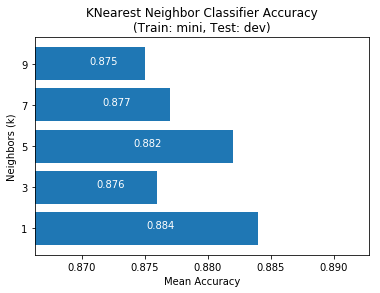

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



In [0]:
def P2(k_values):
    """
    Evaluates KNearestNeighbor classifier accuracy using models trained on "mini" data set.

    Arguments
    ---------
    k_values: list

    List of k values with which to create and evaluate KNearestNeighbor classifiers
    """

    assert (type(k_values) is list), "k_values must be of type list"
    assert (len(k_values) > 0), "k_values list must not be empty"

    # Iterate over the list of k values, creating and evaluating the accuracy of 
    # K-nearest-neighbor classifiers for each value of k
    k_list = list()
    accuracy_list = list()
    k1_predicted = None
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors = k)
        classifier.fit(X = mini_train_data, y = mini_train_labels)
        k_list.append(str(k))
        accuracy_list.append(classifier.score(X = dev_data, y = dev_labels))
        if (k == 1):
            k1_predicted = classifier.predict(X = dev_data)

    # Plot the data using a horizontal histogram
    fig, ax = plt.subplots()
    xlim_minimum = min(accuracy_list) * 0.99
    ax.set(
        xlim = [xlim_minimum, max(accuracy_list) * 1.01],
        title = "KNearest Neighbor Classifier Accuracy\n(Train: mini, Test: dev)",
        xlabel = "Mean Accuracy",
        ylabel = "Neighbors (k)"
    )
    for i, accuracy in enumerate(accuracy_list):
        ax.text(xlim_minimum + (accuracy - xlim_minimum) / 2, y = i, s = accuracy, color = "white")
    ax.barh(k_list, accuracy_list)
    plt.show()

    # Print the classification report showing the performance of the k=1 classifier for each digit
    # represented in the development data set    
    print(classification_report(dev_labels, k1_predicted))

k_values = [1, 3, 5, 7, 9]
P2(k_values)

ANSWER:

Two digits stand out in the *k*=1 classifier's classification report:

*   **8** - Digit "8" has the lowest *recall* value among the ten digits; i.e. the lowest ratio of correctly-identified digits to the number of relevant values that should have been returned.
*   **9** - Digit "9" has the lowest *precision* value among the ten digits; i.e. the lowest ratio of correctly-identified digits to the total number of values that should have been returned.

However, if "difficulty" is defined as the lowest mean value among digits -- (*precision* + *recall*) / 2 -- in other words the *f1 score* -- digit 8 has the lowest f1 score.




(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [0]:
def P3(train_sizes, accuracies):
    """
    Trains, evaluates accuracy, and performs MNIST data predictions using specified training set
    sizes.

    A KNearestNeighbor classifier with k = 1 is used for each training set size.

    Arguments
    ---------
    train_sizes: list

    Integer list of sizes of various training data sets with which to train that classifier

    accuracies: list

    List with no elements.  P3 returns classifier accuracy and elapsed time for predictions in the
    form of a two-element tuple -- one tuple per training set size evaluated.  Elements of each
    tuple are classifier accuracy and elapsed time of prediction in seconds.
    """

    assert (type(train_sizes) is list), "train_sizes must be of type list"
    assert (len(train_sizes) > 0), "train_sizes must not be empty"
    assert (all(isinstance(train_size, int) for train_size in train_sizes)), "train_sizes list must contain only integers"
    assert (type(accuracies) is list), "accuracies must be of type list"
    assert (len(accuracies) == 0), "accuracies must be empty"

    # Iterate through the list of training data sizes, building and evaluating KNearestNeighbor
    # classifiers of the specified sizes
    for train_size in train_sizes:

        # Identify the training data set
        cur_train_data, cur_train_labels = X[:train_size], Y[:train_size]

        # Create and train/fit the KNearestNeighbor classifier using k = 1
        cur_classifier = KNeighborsClassifier(n_neighbors = 1)
        cur_classifier.fit(X = cur_train_data, y = cur_train_labels)

        # Calculate the classifier's accuracy
        cur_accuracy = cur_classifier.score(X = dev_data, y = dev_labels)

        # Perform predictions using test data, and calculate each prediction's elapsed time
        time_begin = time.time()
        cur_classifier.predict(X = dev_data)
        seconds_elapsed = time.time() - time_begin

        # Append the accuracy-elapsed time tuple to the specified "accuracies" list
        accuracies.append((cur_accuracy, seconds_elapsed))

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

# Create lists from each tuple returned by P3
accuracy_list = [accuracy[0] for accuracy in accuracies]
elapsed_time_list = [round(accuracy[1], 3) for accuracy in accuracies]

# Create and render the horizontal histogram for classifier accuracies
fig, ax = plt.subplots()
xlim_minimum = min(accuracy_list) * 0.9
ax.set(
    xlim = [xlim_minimum, max(accuracy_list) * 1.01],
    title = "KNearest Neighbor Classifier Accuracy\n(Train: <variable>, Test: dev)",
    xlabel = "Mean Accuracy",
    ylabel = "Training Size"
)
for i, accuracy in enumerate(accuracy_list):
    ax.text(xlim_minimum + (accuracy - xlim_minimum) / 2, y = i, s = accuracy)
ax.barh([str(train_size) for train_size in train_sizes], accuracy_list)
plt.show()

# Create and render the horizontal histogram for classifiers' prediction's elapsed times
fig, ax = plt.subplots()
ax.set(
    xlim = [0, max(elapsed_time_list) * 1.01],
    title = "KNearest Neighbor Predictions - Elapsed Times\n(Train: <variable>, Test: dev)",
    xlabel = "Elapsed Time (Seconds)",
    ylabel = "Training Size"
)
for i, elapsed_time in enumerate(elapsed_time_list):
    if (elapsed_time < 5):
        ax.text(elapsed_time + 1, y = i, s = elapsed_time)
    else:
        ax.text(xlim_minimum + (elapsed_time - xlim_minimum) / 2, y = i, s = elapsed_time)
ax.barh([str(train_size) for train_size in train_sizes], elapsed_time_list)
plt.show()


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [0]:
#def P4():

### STUDENT START ###
    

### STUDENT END ###

#P4()

ANSWER:

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [0]:
#def P5():

### STUDENT START ###

    
### STUDENT END ###

#P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [0]:
#def P6():
    
### STUDENT START ###


### STUDENT END ###

#P6()

ANSWER:

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [0]:
#def P7():

### STUDENT START ###


    
### STUDENT END ###

#P7()

ANSWER:

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [0]:
#def P8(alphas):

### STUDENT START ###



### STUDENT END ###

#alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
#nb = P8(alphas)

In [0]:
#print nb.best_params_

ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [0]:
#def P9():

### STUDENT END ###


### STUDENT END ###

#gnb = P9()

ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [0]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [0]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [0]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()